In [1]:
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
from torch.nn import Embedding, LSTM, Linear
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

from random import shuffle

import re
import pymorphy2
from nltk.corpus import stopwords

import time

import json

from tqdm import tqdm

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Загрузка датасета

In [85]:
train_df = pd.read_csv('datasets/Training_data_marked.csv')
test_df = pd.read_csv('datasets/Test_data_marked.csv')
df = pd.concat([train_df, test_df], ignore_index=True)
df

,Общая оценка,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Текст отзыва
0,4,4.0,4.0,5.0,4.0,4.0,5.0,"Очень достойный отель с прекрасными номерами, ..."
1,4,NaN,3.0,NaN,NaN,4.0,4.0,"Остановились в Барселоне проездом, т.к. нужно ..."
2,4,3.0,3.0,5.0,5.0,3.0,4.0,Типичная сетевая гостиница. Главный плюс-шикар...
3,1,NaN,NaN,NaN,2.0,1.0,1.0,"Начнем с того, что в этом отеле не берут деньг..."
4,5,NaN,NaN,NaN,NaN,NaN,NaN,"Отель находится в отдалении от центра,но пешко..."
...,...,...,...,...,...,...,...,...
57199,5,4.0,4.0,5.0,5.0,4.0,5.0,"Для нас было плюсом, что в этом отеле можно ос..."
57200,5,5.0,4.0,5.0,5.0,5.0,5.0,Очень понравился отель.Хорошие номера с кухней...
57201,5,5.0,4.0,5.0,5.0,5.0,4.0,"В Петербурге бываю очень часто, поэтому появле..."
57202,5,5.0,5.0,5.0,5.0,5.0,5.0,Изумительное место! Я просто не ожидала такого...


In [86]:
df = df.rename(columns={'Текст отзыва': 'text', 'Общая оценка': 'score'})
df = df[['score', 'text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57204 entries, 0 to 57203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   57204 non-null  int64 
 1   text    57053 non-null  object
dtypes: int64(1), object(1)
memory usage: 893.9+ KB


In [87]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57039 entries, 0 to 57203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   57039 non-null  int64 
 1   text    57039 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [95]:
def draw_statistics(df):
    x = df.groupby(by='score').count()
    plt.pie(x['text'], labels=x.index,  autopct='%.1f%%')
    plt.title('Соотношение оценок в коментариях')
    print(x['text'])

score
1     1452
2     2026
3     6356
4    18208
5    28997
Name: text, dtype: int64


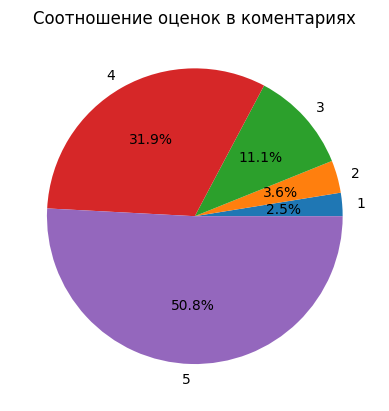

In [96]:
draw_statistics(df)

# Просмотр отзывов

In [8]:
def get_reviews(score, len_):
    idx = list(df[df['score'] == score].index)
    shuffle(idx)
    return list(df['text'][idx[:len_]])

In [16]:
for i in range(1, 6):
    print('Оценка:', i, get_reviews(i, 3), end='\n\n')

Оценка: 1 ['Каждый кубический сантиметр воздуха в отеле пропитан невыносимой наимерзейшей вонью кошачьей, пёсьей, волчьей, медвежьей и слоновьей ссанины. Чтобы получилось уснуть, пришлось курить в номере - только так запах прятался на несколько минут. И это не смотря на расположение кровати прямо рядом с открытым настежь окном.Есть множество и других огромнейших минусов, но они все меркнут в сравнении с вонью.', 'Останавливались в отеле вдвоем с мужем в июне 2014 года. Заказали номер как было заявлено на сайте высшей категории. Сразу напрягло, что номер оказался напротив лифта и был смежным (видимо он подразумевался как двухкомнатный, просто дверь во вторую комнату закрывается на ключ). Как по заказу в этот смежный номер поселили семейную пару с маленьким ребенком, который конечно плакал по ночам, ломился в эту закрытую дверь в коридоре и просыпался в пять утра. Но на все это можно было бы закрыть глаза, у нас тоже были маленькие дети, закрывали поплотнее дверь в прихожую и спали. Само

# Балансировка данных

score
1    1452
2    2026
4    1739
5    1739
Name: text, dtype: int64


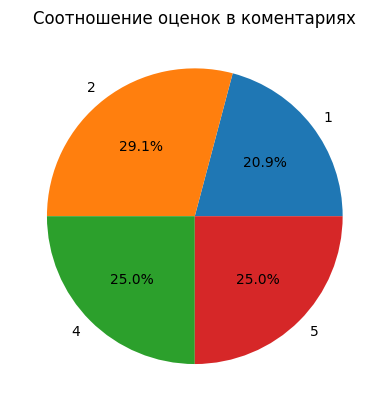

In [98]:
df_b = pd.concat([df[df['score']==1], df[df['score']==2], df[df['score']==4][:1739], df[df['score']==5][:1739]])
draw_statistics(df_b)

In [11]:
(1452+2026)/2

1739.0

# Обработка текста

In [8]:
def clear_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Удаление ссылок
    text = re.sub('"[\S]+"', ' ', text) # Удаление названий. Пример: "ООО ..."

    com_w = re.findall('[а-яё]{1}[А-ЯЁ]{1}', text)
    for i in com_w:
        text = text.replace(i, f'{i[0]} {i[1]}')
    
    text = text.lower().replace("ё", "е")

    for i in list('.?!(),-;:#$%&\\/*+<=>@[]') + ['...']:
        text = text.replace(i, ' ') # В конце строки часто не ставят пробелов
        # из-за этого после обработки два слова склеиваются и перестают нести смысловую нагрузку для сети
    
    symbols = re.findall("[а-я\s]", text) # Оставляем только буквы
    text = ''.join(symbols)
    text = re.sub(' +', ' ', text) # Оставляем между словами 1 пробел
    return text.strip()

In [9]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

def stemming(text):
    text = text.split()
    new_text = []

    for i in text:
        tmp = morph.parse(i)[0]
        if not 'UNKN' in tmp.tag: # Если слово написано с ошибкой или несуществующее слово
            new_text.append(tmp.normal_form)
    
    return ' '.join(new_text)

In [10]:
def preprocess_text(text):
    text = clear_text(text)
    text = stemming(text)
    return text

In [13]:
i = 1
print(df_b['text'][i], end='\n\n')
print(preprocess_text(df_b['text'][i]))

Остановились в Барселоне проездом, т.к. нужно было посетить консульство РФ. Расположение, для посещения консульства - неплохо, дошли до него пешком (хотя идти пришлось минут 25 и в горку). Сама гостиница - достаточно хороша, завтрак - замечательный. В гостинице подземная парковка - заезжать туда нужно сразу, хотя она и рядом с главным входом (погуглите стрит вью) и на самый нижний уровень. У нас машина высокая (2м), но потолки парковки достаточно высокие и проблемы не было. Оттуда с вещами на лифте - в лобби. Есть достаточно простенький но функциональный спорт зал. Номера - нормальные, в принципе все понравилось.

остановиться в барселона проезд так к нужно быть посетить консульство рф расположение для посещение консульство неплохо дойти до он пешком хотя идти прийтись минута и в горка сам гостиница достаточно хороший завтрак замечательный в гостиница подземный парковка заезжать туда нужно сразу хотя она и рядом с главный вход погуглита стрит вить и на самый нижний уровень у мы машина 

In [15]:
%%time
df_pre = df_b.copy()
df_pre['text'] = df_pre['text'].map(lambda x: preprocess_text(x))

CPU times: user 1min 58s, sys: 1.65 ms, total: 1min 58s
Wall time: 1min 58s


In [18]:
df_pre.to_csv('datasets/preprocess_ds.csv')

In [2]:
df_pre =  pd.read_csv('datasets/preprocess_ds.csv', index_col=0)
df_pre['text'] = df_pre['text'].map(lambda x: str(x))

# Удаление stopwords

In [16]:
print(stopwords.words("russian"))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [17]:
stop_list = stopwords.words("russian")
stop_list.extend(['это', 'который', 'всё', 'весь', 'свой', 'наш', 'ещё', 'также'])

for i in ['не', 'нет', 'вдруг', 'ни', 'опять', 'ничего', 'без', 'тоже', 'совсем', 
          'хорошо', 'лучше', 'да', 'никогда', 'иногда', 'нельзя']:
    stop_list.remove(i)

# Проверка слов

In [99]:
# https://github.com/danakt/russian-words
ru_words = ''
with open('russian.txt', 'r', encoding='WINDOWS-1251') as f:
    ru_words = f.read()
ru_words = ru_words.lower().split()
len(ru_words)

1532652

In [20]:
tokens = set(' '.join(df_pre['text']).split())

wrong_words = set(list(tokens)) - set(ru_words)
len(tokens), len(wrong_words), len(wrong_words)/len(tokens)

(21050, 4493, 0.2134441805225653)

# Токенизация

In [21]:
unique_words = tokens - set(stop_list) - wrong_words
tokens = {value: key for key, value in enumerate(unique_words, start=1)}
print('Количество токенов:', len(tokens))

Количество токенов: 16458


In [22]:
with open('datasets/vocabulary.json', 'w') as f:
    json.dump(tokens, f)

In [3]:
with open('datasets/vocabulary.json', 'r') as f:
    tokens = json.load(f)

In [4]:
def text2numbers(text, dict_): 
    text = text.split()
    sequence = []

    for i in text:
        if i in dict_.keys():
            sequence.append(dict_[i])

    return sequence

In [5]:
def texts2tokens(row):
    return [text2numbers(i, dict_=tokens) for i in row]

In [6]:
texts = texts2tokens(df_pre['text'])

## Преобразовываем тексты к одной длине

In [10]:
text_len = [len(i) for i in texts]

print('Количество слов:')
print('Min:', np.min(text_len))
print('Max:', np.max(text_len))
print('Mean:', np.mean(text_len))
print('Median:', np.median(text_len))

Количество слов:
Min: 0
Max: 990
Mean: 68.92682576193215
Median: 50.0


Text(0.5, 1.0, 'Количество слов в предложениях')

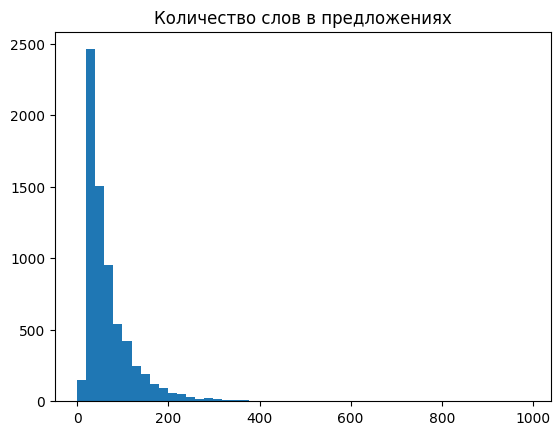

In [11]:
plt.hist(text_len, bins=50)
plt.title('Количество слов в предложениях')

In [12]:
sum([1 for i in texts if len(i) == 0])

2

In [7]:
def set_text_len(texts, max_len):
    array = np.zeros([len(texts), max_len])

    i = 0
    for value in texts:
        tmp = max_len-len(value)
        tmp = tmp if tmp > 0 else 0

        text = np.concatenate((value[:max_len], np.zeros(tmp)))
        array[i] = text
        i+=1

    return array 

In [8]:
max_len = 200
texts_same_len = set_text_len(texts, max_len)

texts_same_len.shape

(6956, 200)

In [31]:
np.save('datasets/texts_same_len.npy', texts_same_len)

In [25]:
texts_same_len = np.load('datasets/texts_same_len.npy')

## Преобразование результирующей колонки

In [15]:
df_pre['score'].unique()

array([1, 2, 4, 5])

In [9]:
def rules(row):
    score = row['score']
    new_score = -1

    if score in [4, 5]:
        new_score = 5 # Положительные
    elif score in [1, 2]:
        new_score = 1 # Отрицательные


    row['score'] = new_score
    return row

def merge_categories(df):
    return df.apply(rules, axis=1)

In [10]:
df_pre = merge_categories(df_pre)

In [11]:
score_enc = OneHotEncoder(handle_unknown='ignore')
X = df_pre['score'].to_numpy().reshape(-1, 1)

unique_items = np.unique(X).reshape(-1, 1)
score_enc.fit(unique_items)

print('Категории:', score_enc.categories_, sep='\n')
print()
for i, desc in zip(score_enc.categories_[0], ['Отрицательные\t', 'Положительные\t']):
    print(desc, i, score_enc.transform(np.array([i]).reshape(-1, 1)).toarray())

Категории:
[array([1, 5])]

Отрицательные	 1 [[1. 0.]]
Положительные	 5 [[0. 1.]]


In [12]:
def score_one_hot_encoder(row):
    array = row.to_numpy().reshape(-1, 1)
    return score_enc.transform(array).toarray()

In [13]:
score = score_one_hot_encoder(df_pre['score'])

In [38]:
np.save('datasets/score.npy', score)

In [24]:
score = np.load('datasets/score.npy')

# Создание DataLoader

In [21]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.IntTensor(self.X[idx]), torch.IntTensor([self.y[idx]])

In [14]:
len(score)

6956

In [17]:
X_train, X_test, y_train, y_test = train_test_split(texts_same_len, score, test_size=0.20, random_state=87)
len(X_train), len(X_test)

(5564, 1392)

In [53]:
1390/4

347.5

In [24]:
batch_size = 350

train = TextDataset(X_train, y_train)
test = TextDataset(X_test, y_test)

train_loader = DataLoader(train,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [26]:
x, y = next(iter(train))
x.shape, y.shape, y #, x

(torch.Size([200]), torch.Size([1, 2]), tensor([[0, 1]], dtype=torch.int32))

In [64]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([350, 200]), torch.Size([350, 1, 2]))

# Создание модели

In [95]:
e = Embedding(10, 3)
e(torch.IntTensor([1, 2, 3, 1]))

tensor([[ 0.9233, -0.2279, -0.3224],
        [ 1.4868,  0.8123,  0.2109],
        [ 0.1834,  0.0880,  0.3074],
        [ 0.9233, -0.2279, -0.3224]], grad_fn=<EmbeddingBackward0>)

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, num_layers=1, l_dropout=0, dropout=0):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = Embedding(input_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=l_dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        output = self.dropout(output)
        output = self.fc(output[:, -1, :])
        output = self.sig(output).reshape(-1, 1, self.output_size)
       
        return output

In [28]:
def accuracy(model, data_loader, device):
    correct = 0
    total_loss = 0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.float().to(device)
            outputs = model(X)
            total_loss += loss_fn(outputs, y)
            for pred, target in zip(outputs, y):
                correct += pred.argmax() == target.argmax()
                
        total = len(data_loader) * data_loader.batch_size
        # print(total, correct)
        # print('Loss', total_loss)
    return correct.float()/total * 100, total_loss

In [29]:
def train(model, epochs = 10, prefix='e'):
    start = time.time()
    acc_score = {'train': [], 'test': [], 'train_loss':[], 'test_loss': []}
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            text, labels = data
            text = text.to(device)
            labels = labels.to(device)
    
        
            optimizer.zero_grad()
            outputs = model(text)
            loss = loss_fn(outputs, labels.float())
            loss.backward()
            optimizer.step()

        torch.save(model, f'models/{prefix}{epoch}_lstm_3.pt')
    
        with torch.set_grad_enabled(False):
            train_acc, train_loss = accuracy(model, train_loader, device)
            test_acc, test_loss = accuracy(model, test_loader, device)
            
            acc_score['train'].append(train_acc)
            acc_score['test'].append(test_acc)
            acc_score['train_loss'].append(train_loss)
            acc_score['test_loss'].append(test_loss)

            tqdm.write(f'Epoch: {epoch}')
            tqdm.write(f'Train accuracy: {train_acc:.2f}% Loss: {train_loss:.2f}')
            tqdm.write(f'Test accuracy: {test_acc:.2f}% Loss: {test_loss:.2f}')
   
        
    print(f'Total time: {(time.time() - start)/60:.2f} min')
    print(f'Test accuracy: {accuracy(model, test_loader, device)[0]:.2f}%')

    return acc_score

In [30]:
def to_list(tensors):
    return [i.cpu().item() for i in tensors]

In [31]:
def learn_chart(score):
    data = {key: to_list(value) for key, value in score.items()}

    fig, ax = plt.subplots(1, 2)
    fig.tight_layout()
    
    ax[0].plot(data['train'], label = 'Train')
    ax[0].plot(data['test'], label = 'Test')
    ax[0].set_title("Accuracy")
    ax[0].legend()
    ax[0].grid()
    
    ax[1].plot(data['train_loss'], label = 'Train')
    ax[1].plot(data['test_loss'], label = 'Test')
    ax[1].set_title("Loss")
    plt.legend()
    plt.grid()

In [67]:
torch.cuda.empty_cache()

## 1 model

In [32]:
model = LSTM(input_size=len(tokens) + 1,
            embedding_dim=64,
            hidden_size=128,
            output_size=2,
            num_layers=1,
            l_dropout=0,
            dropout=0
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)

LSTM(
  (embedding): Embedding(16459, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (sig): Sigmoid()
)


In [33]:
acc_score = train(model, epochs=150, prefix='1m_')

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 11.37it/s]


Epoch: 0
Train accuracy: 52.11% Loss: 11.07
Test accuracy: 50.43% Loss: 2.77


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.46it/s]


Epoch: 1
Train accuracy: 52.64% Loss: 11.01
Test accuracy: 51.21% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.98it/s]


Epoch: 2
Train accuracy: 53.00% Loss: 10.97
Test accuracy: 51.64% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.98it/s]


Epoch: 3
Train accuracy: 52.64% Loss: 11.01
Test accuracy: 51.07% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.79it/s]


Epoch: 4
Train accuracy: 52.70% Loss: 11.01
Test accuracy: 51.07% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.45it/s]


Epoch: 5
Train accuracy: 52.68% Loss: 11.00
Test accuracy: 51.29% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.34it/s]


Epoch: 6
Train accuracy: 52.77% Loss: 10.98
Test accuracy: 51.29% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.04it/s]


Epoch: 7
Train accuracy: 52.82% Loss: 10.96
Test accuracy: 51.43% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.06it/s]


Epoch: 8
Train accuracy: 52.98% Loss: 10.93
Test accuracy: 51.71% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.08it/s]


Epoch: 9
Train accuracy: 53.80% Loss: 10.86
Test accuracy: 52.64% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.09it/s]


Epoch: 10
Train accuracy: 53.43% Loss: 10.89
Test accuracy: 51.57% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.41it/s]


Epoch: 11
Train accuracy: 53.38% Loss: 10.89
Test accuracy: 51.57% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.69it/s]


Epoch: 12
Train accuracy: 53.55% Loss: 10.87
Test accuracy: 51.57% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.69it/s]


Epoch: 13
Train accuracy: 53.73% Loss: 10.84
Test accuracy: 52.07% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.26it/s]


Epoch: 14
Train accuracy: 54.20% Loss: 10.79
Test accuracy: 52.86% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.52it/s]


Epoch: 15
Train accuracy: 55.14% Loss: 10.74
Test accuracy: 54.00% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.01it/s]


Epoch: 16
Train accuracy: 52.95% Loss: 10.89
Test accuracy: 50.79% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.42it/s]


Epoch: 17
Train accuracy: 52.93% Loss: 10.86
Test accuracy: 50.79% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.67it/s]


Epoch: 18
Train accuracy: 52.96% Loss: 10.84
Test accuracy: 50.93% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.89it/s]


Epoch: 19
Train accuracy: 53.00% Loss: 10.81
Test accuracy: 51.00% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.63it/s]


Epoch: 20
Train accuracy: 53.07% Loss: 10.78
Test accuracy: 51.21% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.01it/s]


Epoch: 21
Train accuracy: 53.16% Loss: 10.75
Test accuracy: 51.29% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.96it/s]


Epoch: 22
Train accuracy: 53.66% Loss: 10.71
Test accuracy: 51.57% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.91it/s]


Epoch: 23
Train accuracy: 54.93% Loss: 10.61
Test accuracy: 53.50% Loss: 2.70


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.93it/s]


Epoch: 24
Train accuracy: 53.09% Loss: 10.79
Test accuracy: 50.79% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.95it/s]


Epoch: 25
Train accuracy: 53.09% Loss: 10.76
Test accuracy: 50.93% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.69it/s]


Epoch: 26
Train accuracy: 53.16% Loss: 10.74
Test accuracy: 51.07% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.68it/s]


Epoch: 27
Train accuracy: 53.18% Loss: 10.72
Test accuracy: 51.14% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.98it/s]


Epoch: 28
Train accuracy: 53.21% Loss: 10.71
Test accuracy: 51.21% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.84it/s]


Epoch: 29
Train accuracy: 53.34% Loss: 10.69
Test accuracy: 51.21% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.83it/s]


Epoch: 30
Train accuracy: 53.46% Loss: 10.68
Test accuracy: 51.43% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.72it/s]


Epoch: 31
Train accuracy: 53.71% Loss: 10.65
Test accuracy: 51.43% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 32
Train accuracy: 54.11% Loss: 10.61
Test accuracy: 51.79% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.33it/s]


Epoch: 33
Train accuracy: 57.38% Loss: 10.37
Test accuracy: 56.00% Loss: 2.66


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s]


Epoch: 34
Train accuracy: 56.27% Loss: 10.41
Test accuracy: 55.14% Loss: 2.68


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.85it/s]


Epoch: 35
Train accuracy: 56.64% Loss: 10.34
Test accuracy: 54.93% Loss: 2.65


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.87it/s]


Epoch: 36
Train accuracy: 53.73% Loss: 10.70
Test accuracy: 51.50% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.85it/s]


Epoch: 37
Train accuracy: 53.25% Loss: 10.73
Test accuracy: 51.21% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.91it/s]


Epoch: 38
Train accuracy: 53.30% Loss: 10.71
Test accuracy: 51.29% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.72it/s]


Epoch: 39
Train accuracy: 53.48% Loss: 10.68
Test accuracy: 51.50% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.96it/s]


Epoch: 40
Train accuracy: 53.66% Loss: 10.66
Test accuracy: 51.50% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.10it/s]


Epoch: 41
Train accuracy: 54.02% Loss: 10.63
Test accuracy: 51.93% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.77it/s]


Epoch: 42
Train accuracy: 54.55% Loss: 10.57
Test accuracy: 52.50% Loss: 2.70


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.82it/s]


Epoch: 43
Train accuracy: 57.62% Loss: 10.33
Test accuracy: 56.50% Loss: 2.65


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.72it/s]


Epoch: 44
Train accuracy: 73.71% Loss: 8.75
Test accuracy: 72.50% Loss: 2.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.63it/s]


Epoch: 45
Train accuracy: 80.21% Loss: 7.20
Test accuracy: 79.21% Loss: 1.92


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 46
Train accuracy: 86.80% Loss: 5.34
Test accuracy: 84.00% Loss: 1.60


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 47
Train accuracy: 84.91% Loss: 5.63
Test accuracy: 83.86% Loss: 1.57


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 48
Train accuracy: 89.64% Loss: 4.67
Test accuracy: 86.07% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 49
Train accuracy: 80.21% Loss: 7.42
Test accuracy: 76.36% Loss: 2.03


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 50
Train accuracy: 88.50% Loss: 5.71
Test accuracy: 85.07% Loss: 1.66


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 51
Train accuracy: 90.75% Loss: 4.13
Test accuracy: 87.64% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 52
Train accuracy: 92.09% Loss: 3.68
Test accuracy: 88.57% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 53
Train accuracy: 92.20% Loss: 3.64
Test accuracy: 88.29% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 54
Train accuracy: 92.61% Loss: 3.39
Test accuracy: 88.93% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 55
Train accuracy: 92.71% Loss: 3.31
Test accuracy: 89.29% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.69it/s]


Epoch: 56
Train accuracy: 93.09% Loss: 3.14
Test accuracy: 89.21% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 57
Train accuracy: 93.29% Loss: 3.04
Test accuracy: 89.50% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 58
Train accuracy: 93.46% Loss: 3.09
Test accuracy: 89.36% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 59
Train accuracy: 93.62% Loss: 2.88
Test accuracy: 89.79% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 60
Train accuracy: 93.38% Loss: 2.90
Test accuracy: 89.21% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 61
Train accuracy: 93.91% Loss: 2.74
Test accuracy: 90.07% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s]


Epoch: 62
Train accuracy: 94.54% Loss: 2.77
Test accuracy: 89.57% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 63
Train accuracy: 92.91% Loss: 3.39
Test accuracy: 88.71% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 64
Train accuracy: 94.29% Loss: 2.56
Test accuracy: 89.71% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 65
Train accuracy: 94.70% Loss: 2.61
Test accuracy: 89.50% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 66
Train accuracy: 94.91% Loss: 2.43
Test accuracy: 90.21% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 67
Train accuracy: 94.80% Loss: 2.42
Test accuracy: 90.07% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 68
Train accuracy: 94.55% Loss: 2.40
Test accuracy: 90.00% Loss: 1.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s]


Epoch: 69
Train accuracy: 94.95% Loss: 2.38
Test accuracy: 89.86% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.66it/s]


Epoch: 70
Train accuracy: 95.00% Loss: 2.31
Test accuracy: 90.29% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 71
Train accuracy: 94.91% Loss: 2.50
Test accuracy: 89.36% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.63it/s]


Epoch: 72
Train accuracy: 95.38% Loss: 2.30
Test accuracy: 90.07% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 73
Train accuracy: 95.23% Loss: 2.37
Test accuracy: 90.29% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 74
Train accuracy: 95.27% Loss: 2.28
Test accuracy: 90.86% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 75
Train accuracy: 95.27% Loss: 2.35
Test accuracy: 89.86% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 76
Train accuracy: 95.50% Loss: 2.25
Test accuracy: 90.36% Loss: 1.26


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 77
Train accuracy: 95.75% Loss: 2.18
Test accuracy: 90.43% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s]


Epoch: 78
Train accuracy: 95.84% Loss: 2.12
Test accuracy: 90.29% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 79
Train accuracy: 95.80% Loss: 2.14
Test accuracy: 90.57% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 80
Train accuracy: 95.82% Loss: 2.12
Test accuracy: 90.36% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 81
Train accuracy: 95.82% Loss: 2.12
Test accuracy: 90.57% Loss: 1.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 82
Train accuracy: 95.86% Loss: 2.10
Test accuracy: 90.93% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.65it/s]


Epoch: 83
Train accuracy: 95.59% Loss: 2.21
Test accuracy: 89.71% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.67it/s]


Epoch: 84
Train accuracy: 95.82% Loss: 2.11
Test accuracy: 90.71% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 85
Train accuracy: 95.77% Loss: 2.13
Test accuracy: 90.71% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 86
Train accuracy: 95.80% Loss: 2.13
Test accuracy: 90.64% Loss: 1.24


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 87
Train accuracy: 95.80% Loss: 2.12
Test accuracy: 90.64% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 88
Train accuracy: 95.54% Loss: 2.19
Test accuracy: 89.43% Loss: 1.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 89
Train accuracy: 95.93% Loss: 2.06
Test accuracy: 90.64% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 90
Train accuracy: 95.86% Loss: 2.11
Test accuracy: 90.29% Loss: 1.52


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.98it/s]


Epoch: 91
Train accuracy: 95.75% Loss: 2.15
Test accuracy: 90.29% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch: 92
Train accuracy: 95.84% Loss: 2.08
Test accuracy: 90.43% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.44it/s]


Epoch: 93
Train accuracy: 93.59% Loss: 3.02
Test accuracy: 87.36% Loss: 1.60


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.34it/s]


Epoch: 94
Train accuracy: 94.95% Loss: 2.45
Test accuracy: 90.21% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 95
Train accuracy: 95.95% Loss: 2.08
Test accuracy: 90.29% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.06it/s]


Epoch: 96
Train accuracy: 96.14% Loss: 1.98
Test accuracy: 90.29% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 97
Train accuracy: 96.04% Loss: 2.06
Test accuracy: 89.93% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.65it/s]


Epoch: 98
Train accuracy: 96.20% Loss: 1.95
Test accuracy: 90.21% Loss: 1.19


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 99
Train accuracy: 95.93% Loss: 1.91
Test accuracy: 90.21% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 100
Train accuracy: 96.11% Loss: 1.97
Test accuracy: 90.36% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.64it/s]


Epoch: 101
Train accuracy: 96.29% Loss: 1.88
Test accuracy: 90.50% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 102
Train accuracy: 96.41% Loss: 1.80
Test accuracy: 90.43% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 103
Train accuracy: 96.36% Loss: 1.86
Test accuracy: 90.36% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 104
Train accuracy: 96.45% Loss: 1.79
Test accuracy: 90.57% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 105
Train accuracy: 96.55% Loss: 1.75
Test accuracy: 90.57% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 106
Train accuracy: 96.59% Loss: 1.73
Test accuracy: 90.29% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 107
Train accuracy: 96.61% Loss: 1.73
Test accuracy: 90.14% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 108
Train accuracy: 89.00% Loss: 5.65
Test accuracy: 84.50% Loss: 2.04


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 109
Train accuracy: 95.54% Loss: 3.16
Test accuracy: 89.00% Loss: 1.68


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 110
Train accuracy: 96.07% Loss: 2.18
Test accuracy: 88.93% Loss: 1.49


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 111
Train accuracy: 96.34% Loss: 1.89
Test accuracy: 88.86% Loss: 1.61


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 112
Train accuracy: 96.46% Loss: 1.85
Test accuracy: 88.29% Loss: 1.97


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 113
Train accuracy: 96.64% Loss: 1.72
Test accuracy: 89.50% Loss: 1.50


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 114
Train accuracy: 96.79% Loss: 1.65
Test accuracy: 90.07% Loss: 1.42


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 115
Train accuracy: 96.96% Loss: 1.56
Test accuracy: 90.43% Loss: 1.53


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.60it/s]


Epoch: 116
Train accuracy: 96.64% Loss: 1.71
Test accuracy: 89.79% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 117
Train accuracy: 96.95% Loss: 1.57
Test accuracy: 90.36% Loss: 1.57


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.47it/s]


Epoch: 118
Train accuracy: 96.96% Loss: 1.57
Test accuracy: 90.57% Loss: 1.50


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 119
Train accuracy: 97.02% Loss: 1.53
Test accuracy: 90.43% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 120
Train accuracy: 96.98% Loss: 1.54
Test accuracy: 89.79% Loss: 1.82


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 121
Train accuracy: 96.98% Loss: 1.56
Test accuracy: 90.14% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.51it/s]


Epoch: 122
Train accuracy: 97.04% Loss: 1.52
Test accuracy: 90.79% Loss: 1.52


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 123
Train accuracy: 96.96% Loss: 1.62
Test accuracy: 90.14% Loss: 1.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 124
Train accuracy: 96.66% Loss: 1.72
Test accuracy: 90.00% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.91it/s]


Epoch: 125
Train accuracy: 97.11% Loss: 1.50
Test accuracy: 90.64% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.06it/s]


Epoch: 126
Train accuracy: 97.18% Loss: 1.45
Test accuracy: 90.36% Loss: 1.69


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 127
Train accuracy: 97.18% Loss: 1.46
Test accuracy: 90.43% Loss: 1.71


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.50it/s]


Epoch: 128
Train accuracy: 97.07% Loss: 1.51
Test accuracy: 90.50% Loss: 1.49


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.50it/s]


Epoch: 129
Train accuracy: 97.20% Loss: 1.45
Test accuracy: 90.29% Loss: 1.62


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 130
Train accuracy: 96.79% Loss: 1.67
Test accuracy: 89.50% Loss: 2.00


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 131
Train accuracy: 97.20% Loss: 1.44
Test accuracy: 90.64% Loss: 1.45


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 132
Train accuracy: 97.27% Loss: 1.41
Test accuracy: 90.86% Loss: 1.47


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 133
Train accuracy: 97.27% Loss: 1.43
Test accuracy: 90.57% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 134
Train accuracy: 97.29% Loss: 1.40
Test accuracy: 91.07% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 135
Train accuracy: 97.30% Loss: 1.39
Test accuracy: 90.93% Loss: 1.47


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 136
Train accuracy: 97.36% Loss: 1.36
Test accuracy: 90.79% Loss: 1.57


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.51it/s]


Epoch: 137
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.86% Loss: 1.53


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 138
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.86% Loss: 1.49


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.49it/s]


Epoch: 139
Train accuracy: 97.36% Loss: 1.36
Test accuracy: 90.86% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 140
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.71% Loss: 1.52


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 141
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.93% Loss: 1.53


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 142
Train accuracy: 97.36% Loss: 1.36
Test accuracy: 90.93% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 143
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.93% Loss: 1.53


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.50it/s]


Epoch: 144
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 91.00% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 145
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 90.93% Loss: 1.55


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 146
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 91.00% Loss: 1.56


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch: 147
Train accuracy: 97.36% Loss: 1.36
Test accuracy: 91.00% Loss: 1.56


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 148
Train accuracy: 97.36% Loss: 1.37
Test accuracy: 91.00% Loss: 1.57


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.51it/s]


Epoch: 149
Train accuracy: 97.36% Loss: 1.36
Test accuracy: 91.00% Loss: 1.57
Total time: 4.05 min
Test accuracy: 91.00%


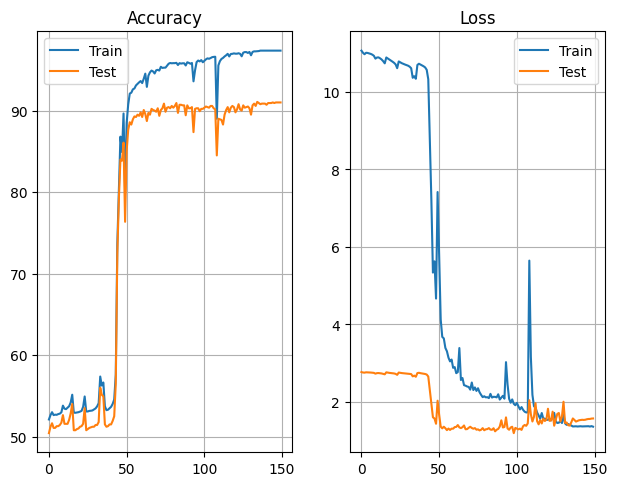

In [34]:
learn_chart(acc_score)

## 2 model

In [57]:
model = LSTM(input_size=len(tokens) + 1,
            embedding_dim=128,
            hidden_size=256,
            output_size=2,
            num_layers=2,
            l_dropout=0.25,
            dropout=0
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)

LSTM(
  (embedding): Embedding(16459, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (sig): Sigmoid()
)


In [58]:
acc_score = train(model, epochs=120, prefix='2m_')

100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


Epoch: 0
Train accuracy: 53.20% Loss: 10.96
Test accuracy: 51.86% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 1
Train accuracy: 53.41% Loss: 10.94
Test accuracy: 52.29% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]


Epoch: 2
Train accuracy: 52.88% Loss: 10.98
Test accuracy: 51.64% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch: 3
Train accuracy: 53.21% Loss: 10.95
Test accuracy: 51.79% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]


Epoch: 4
Train accuracy: 53.41% Loss: 10.89
Test accuracy: 52.21% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch: 5
Train accuracy: 53.98% Loss: 10.88
Test accuracy: 53.07% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.44it/s]


Epoch: 6
Train accuracy: 54.34% Loss: 11.08
Test accuracy: 56.14% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.50it/s]


Epoch: 7
Train accuracy: 53.39% Loss: 10.86
Test accuracy: 54.71% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.48it/s]


Epoch: 8
Train accuracy: 51.30% Loss: 10.94
Test accuracy: 53.36% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 9
Train accuracy: 51.50% Loss: 10.93
Test accuracy: 53.57% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]


Epoch: 10
Train accuracy: 51.55% Loss: 10.93
Test accuracy: 53.57% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 11
Train accuracy: 51.64% Loss: 10.92
Test accuracy: 53.64% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch: 12
Train accuracy: 51.59% Loss: 10.92
Test accuracy: 52.21% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.52it/s]


Epoch: 13
Train accuracy: 51.68% Loss: 10.92
Test accuracy: 53.64% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


Epoch: 14
Train accuracy: 51.75% Loss: 10.91
Test accuracy: 53.71% Loss: 2.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.51it/s]


Epoch: 15
Train accuracy: 51.80% Loss: 10.91
Test accuracy: 54.07% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 16
Train accuracy: 52.07% Loss: 10.90
Test accuracy: 54.14% Loss: 2.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.73it/s]


Epoch: 17
Train accuracy: 52.55% Loss: 10.90
Test accuracy: 50.21% Loss: 2.71


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch: 18
Train accuracy: 52.18% Loss: 10.86
Test accuracy: 51.57% Loss: 2.69


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 19
Train accuracy: 52.93% Loss: 10.84
Test accuracy: 50.93% Loss: 2.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


Epoch: 20
Train accuracy: 53.68% Loss: 10.77
Test accuracy: 51.36% Loss: 2.67


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 21
Train accuracy: 54.61% Loss: 10.67
Test accuracy: 55.29% Loss: 2.62


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.71it/s]


Epoch: 22
Train accuracy: 56.52% Loss: 10.33
Test accuracy: 58.86% Loss: 2.54


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.48it/s]


Epoch: 23
Train accuracy: 67.00% Loss: 8.97
Test accuracy: 68.57% Loss: 2.24


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch: 24
Train accuracy: 79.27% Loss: 7.56
Test accuracy: 78.14% Loss: 1.97


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch: 25
Train accuracy: 79.20% Loss: 7.91
Test accuracy: 78.50% Loss: 1.99


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 26
Train accuracy: 86.75% Loss: 5.55
Test accuracy: 83.14% Loss: 1.61


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 27
Train accuracy: 74.23% Loss: 9.45
Test accuracy: 73.36% Loss: 2.46


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 28
Train accuracy: 68.14% Loss: 9.00
Test accuracy: 65.36% Loss: 2.38


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 29
Train accuracy: 67.80% Loss: 8.79
Test accuracy: 64.07% Loss: 2.36


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.56it/s]


Epoch: 30
Train accuracy: 66.61% Loss: 8.91
Test accuracy: 63.50% Loss: 2.38


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 31
Train accuracy: 67.09% Loss: 8.84
Test accuracy: 64.00% Loss: 2.37


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 32
Train accuracy: 63.32% Loss: 9.39
Test accuracy: 61.50% Loss: 2.43


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch: 33
Train accuracy: 66.07% Loss: 9.05
Test accuracy: 63.43% Loss: 2.37


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 34
Train accuracy: 68.77% Loss: 8.62
Test accuracy: 66.57% Loss: 2.27


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 35
Train accuracy: 69.82% Loss: 8.48
Test accuracy: 68.21% Loss: 2.23


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 36
Train accuracy: 70.82% Loss: 8.27
Test accuracy: 69.29% Loss: 2.20


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.55it/s]


Epoch: 37
Train accuracy: 72.25% Loss: 7.96
Test accuracy: 70.93% Loss: 2.11


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 38
Train accuracy: 71.98% Loss: 7.99
Test accuracy: 70.00% Loss: 2.17


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]


Epoch: 39
Train accuracy: 68.89% Loss: 8.79
Test accuracy: 66.50% Loss: 2.39


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 40
Train accuracy: 78.07% Loss: 7.04
Test accuracy: 75.07% Loss: 1.97


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 41
Train accuracy: 78.62% Loss: 6.64
Test accuracy: 75.36% Loss: 1.92


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 42
Train accuracy: 77.93% Loss: 6.87
Test accuracy: 75.14% Loss: 1.99


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 43
Train accuracy: 81.89% Loss: 5.95
Test accuracy: 79.64% Loss: 1.75


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 44
Train accuracy: 82.20% Loss: 5.84
Test accuracy: 79.43% Loss: 1.74


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 45
Train accuracy: 81.86% Loss: 5.81
Test accuracy: 78.29% Loss: 1.79


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


Epoch: 46
Train accuracy: 81.93% Loss: 5.77
Test accuracy: 78.86% Loss: 1.82


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 47
Train accuracy: 82.50% Loss: 5.58
Test accuracy: 79.64% Loss: 1.77


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 48
Train accuracy: 83.84% Loss: 5.38
Test accuracy: 80.14% Loss: 1.77


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch: 49
Train accuracy: 85.66% Loss: 4.88
Test accuracy: 81.50% Loss: 1.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 50
Train accuracy: 86.52% Loss: 4.59
Test accuracy: 82.57% Loss: 1.65


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch: 51
Train accuracy: 86.52% Loss: 4.51
Test accuracy: 82.50% Loss: 1.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 52
Train accuracy: 86.80% Loss: 4.46
Test accuracy: 82.43% Loss: 1.67


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 53
Train accuracy: 86.89% Loss: 4.37
Test accuracy: 82.50% Loss: 1.67


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch: 54
Train accuracy: 87.05% Loss: 4.31
Test accuracy: 82.36% Loss: 1.67


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 55
Train accuracy: 86.36% Loss: 4.50
Test accuracy: 81.93% Loss: 1.76


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 56
Train accuracy: 84.30% Loss: 5.80
Test accuracy: 80.14% Loss: 2.13


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.55it/s]


Epoch: 57
Train accuracy: 85.57% Loss: 4.67
Test accuracy: 81.07% Loss: 1.73


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 58
Train accuracy: 87.82% Loss: 4.03
Test accuracy: 83.71% Loss: 1.65


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 59
Train accuracy: 88.09% Loss: 3.90
Test accuracy: 83.86% Loss: 1.64


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 60
Train accuracy: 87.98% Loss: 3.96
Test accuracy: 83.43% Loss: 1.72


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 61
Train accuracy: 88.57% Loss: 3.94
Test accuracy: 83.71% Loss: 1.70


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.43it/s]


Epoch: 62
Train accuracy: 88.43% Loss: 3.65
Test accuracy: 84.00% Loss: 1.59


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch: 63
Train accuracy: 91.36% Loss: 3.25
Test accuracy: 87.00% Loss: 1.52


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 64
Train accuracy: 92.82% Loss: 2.84
Test accuracy: 87.43% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 65
Train accuracy: 93.11% Loss: 2.64
Test accuracy: 88.43% Loss: 1.42


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 66
Train accuracy: 92.96% Loss: 2.71
Test accuracy: 87.79% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 67
Train accuracy: 94.12% Loss: 2.86
Test accuracy: 88.93% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.34it/s]


Epoch: 68
Train accuracy: 94.32% Loss: 2.50
Test accuracy: 88.14% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.49it/s]


Epoch: 69
Train accuracy: 95.32% Loss: 2.14
Test accuracy: 89.07% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 70
Train accuracy: 94.36% Loss: 2.54
Test accuracy: 88.29% Loss: 1.49


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 71
Train accuracy: 95.34% Loss: 2.08
Test accuracy: 89.36% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 72
Train accuracy: 96.50% Loss: 1.80
Test accuracy: 89.00% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.49it/s]


Epoch: 73
Train accuracy: 96.66% Loss: 1.73
Test accuracy: 89.29% Loss: 1.42


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 74
Train accuracy: 96.41% Loss: 1.84
Test accuracy: 89.64% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 75
Train accuracy: 89.93% Loss: 3.59
Test accuracy: 84.93% Loss: 1.74


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 76
Train accuracy: 94.46% Loss: 2.49
Test accuracy: 87.21% Loss: 1.46


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 77
Train accuracy: 97.46% Loss: 1.36
Test accuracy: 89.86% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 78
Train accuracy: 96.80% Loss: 1.68
Test accuracy: 89.36% Loss: 1.46


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 79
Train accuracy: 94.18% Loss: 2.78
Test accuracy: 88.14% Loss: 1.55


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 80
Train accuracy: 96.36% Loss: 1.82
Test accuracy: 89.57% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 81
Train accuracy: 96.79% Loss: 1.63
Test accuracy: 90.07% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 82
Train accuracy: 97.04% Loss: 1.52
Test accuracy: 90.07% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 83
Train accuracy: 97.20% Loss: 1.46
Test accuracy: 90.36% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch: 84
Train accuracy: 97.38% Loss: 1.36
Test accuracy: 90.93% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 85
Train accuracy: 97.54% Loss: 1.26
Test accuracy: 90.64% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 86
Train accuracy: 97.45% Loss: 1.27
Test accuracy: 90.07% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 87
Train accuracy: 96.50% Loss: 1.78
Test accuracy: 90.29% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.58it/s]


Epoch: 88
Train accuracy: 93.14% Loss: 3.38
Test accuracy: 87.07% Loss: 1.83


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]


Epoch: 89
Train accuracy: 97.21% Loss: 1.54
Test accuracy: 90.29% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch: 90
Train accuracy: 97.27% Loss: 1.44
Test accuracy: 91.21% Loss: 1.25


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 91
Train accuracy: 97.64% Loss: 1.24
Test accuracy: 90.43% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.65it/s]


Epoch: 92
Train accuracy: 97.25% Loss: 1.36
Test accuracy: 89.71% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.62it/s]


Epoch: 93
Train accuracy: 97.62% Loss: 1.17
Test accuracy: 90.93% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch: 94
Train accuracy: 97.82% Loss: 1.06
Test accuracy: 91.14% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch: 95
Train accuracy: 98.05% Loss: 0.95
Test accuracy: 91.00% Loss: 1.24


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.66it/s]


Epoch: 96
Train accuracy: 98.12% Loss: 0.93
Test accuracy: 91.43% Loss: 1.24


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.67it/s]


Epoch: 97
Train accuracy: 98.20% Loss: 0.90
Test accuracy: 91.36% Loss: 1.26


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.48it/s]


Epoch: 98
Train accuracy: 98.18% Loss: 0.90
Test accuracy: 91.71% Loss: 1.23


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.59it/s]


Epoch: 99
Train accuracy: 98.27% Loss: 0.85
Test accuracy: 91.43% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.61it/s]


Epoch: 100
Train accuracy: 98.32% Loss: 0.83
Test accuracy: 91.36% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.54it/s]


Epoch: 101
Train accuracy: 98.34% Loss: 0.81
Test accuracy: 91.21% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch: 102
Train accuracy: 98.36% Loss: 0.80
Test accuracy: 91.93% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.54it/s]


Epoch: 103
Train accuracy: 98.38% Loss: 0.79
Test accuracy: 91.50% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.49it/s]


Epoch: 104
Train accuracy: 98.38% Loss: 0.78
Test accuracy: 91.07% Loss: 1.41


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.51it/s]


Epoch: 105
Train accuracy: 98.43% Loss: 0.75
Test accuracy: 90.71% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.68it/s]


Epoch: 106
Train accuracy: 98.45% Loss: 0.74
Test accuracy: 91.36% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.46it/s]


Epoch: 107
Train accuracy: 98.43% Loss: 0.73
Test accuracy: 90.71% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.73it/s]


Epoch: 108
Train accuracy: 98.45% Loss: 0.73
Test accuracy: 91.50% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.78it/s]


Epoch: 109
Train accuracy: 98.34% Loss: 0.78
Test accuracy: 91.14% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.74it/s]


Epoch: 110
Train accuracy: 98.43% Loss: 0.76
Test accuracy: 90.86% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch: 111
Train accuracy: 98.45% Loss: 0.74
Test accuracy: 91.29% Loss: 1.45


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch: 112
Train accuracy: 98.45% Loss: 0.73
Test accuracy: 91.21% Loss: 1.41


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch: 113
Train accuracy: 98.45% Loss: 0.72
Test accuracy: 91.29% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch: 114
Train accuracy: 98.46% Loss: 0.72
Test accuracy: 91.57% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch: 115
Train accuracy: 98.46% Loss: 0.74
Test accuracy: 91.43% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch: 116
Train accuracy: 98.46% Loss: 0.72
Test accuracy: 91.21% Loss: 1.45


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch: 117
Train accuracy: 98.46% Loss: 0.73
Test accuracy: 91.07% Loss: 1.47


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch: 118
Train accuracy: 98.46% Loss: 0.72
Test accuracy: 91.14% Loss: 1.50


100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch: 119
Train accuracy: 98.48% Loss: 0.71
Test accuracy: 91.07% Loss: 1.47
Total time: 9.03 min
Test accuracy: 91.21%


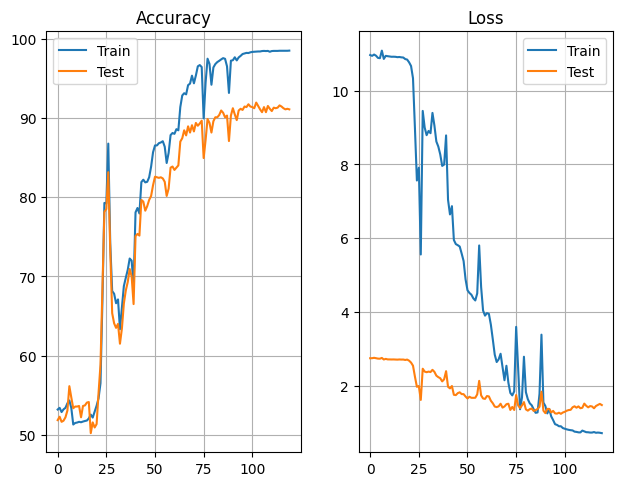

In [59]:
learn_chart(acc_score)

## 3 model

In [70]:
model = LSTM(input_size=len(tokens) + 1,
            embedding_dim=64,
            hidden_size=128,
            output_size=2,
            num_layers=1,
            l_dropout=0,
            dropout=0.25
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)

LSTM(
  (embedding): Embedding(16459, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (sig): Sigmoid()
)


In [71]:
acc_score = train(model, epochs=120, prefix='3m_')

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.61it/s]


Epoch: 0
Train accuracy: 52.14% Loss: 11.06
Test accuracy: 50.50% Loss: 2.77


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 18.20it/s]


Epoch: 1
Train accuracy: 53.05% Loss: 10.96
Test accuracy: 51.64% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 2
Train accuracy: 52.71% Loss: 10.98
Test accuracy: 51.29% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.68it/s]


Epoch: 3
Train accuracy: 52.71% Loss: 10.96
Test accuracy: 51.21% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 4
Train accuracy: 52.77% Loss: 10.92
Test accuracy: 51.21% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.67it/s]


Epoch: 5
Train accuracy: 52.82% Loss: 10.89
Test accuracy: 51.29% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.68it/s]


Epoch: 6
Train accuracy: 53.00% Loss: 10.84
Test accuracy: 51.71% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 7
Train accuracy: 53.54% Loss: 10.78
Test accuracy: 52.36% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 8
Train accuracy: 53.23% Loss: 10.81
Test accuracy: 51.36% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.59it/s]


Epoch: 9
Train accuracy: 53.11% Loss: 10.83
Test accuracy: 51.21% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.62it/s]


Epoch: 10
Train accuracy: 53.11% Loss: 10.81
Test accuracy: 51.29% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.61it/s]


Epoch: 11
Train accuracy: 53.20% Loss: 10.78
Test accuracy: 51.36% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 12
Train accuracy: 53.41% Loss: 10.76
Test accuracy: 51.43% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 13
Train accuracy: 53.48% Loss: 10.74
Test accuracy: 51.50% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 14
Train accuracy: 53.54% Loss: 10.73
Test accuracy: 51.50% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 15
Train accuracy: 53.70% Loss: 10.70
Test accuracy: 51.79% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 16
Train accuracy: 53.82% Loss: 10.68
Test accuracy: 52.00% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.55it/s]


Epoch: 17
Train accuracy: 54.14% Loss: 10.63
Test accuracy: 52.64% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 16.52it/s]


Epoch: 18
Train accuracy: 58.05% Loss: 10.38
Test accuracy: 57.07% Loss: 2.68


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.46it/s]


Epoch: 19
Train accuracy: 53.73% Loss: 10.71
Test accuracy: 51.43% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.41it/s]


Epoch: 20
Train accuracy: 53.82% Loss: 10.70
Test accuracy: 51.79% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch: 21
Train accuracy: 54.04% Loss: 10.67
Test accuracy: 51.64% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.57it/s]


Epoch: 22
Train accuracy: 54.29% Loss: 10.65
Test accuracy: 52.29% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 23
Train accuracy: 55.64% Loss: 10.59
Test accuracy: 54.07% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 24
Train accuracy: 54.07% Loss: 10.69
Test accuracy: 52.07% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.43it/s]


Epoch: 25
Train accuracy: 54.23% Loss: 10.63
Test accuracy: 52.21% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 26
Train accuracy: 54.71% Loss: 10.60
Test accuracy: 53.36% Loss: 2.74


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.50it/s]


Epoch: 27
Train accuracy: 55.45% Loss: 10.55
Test accuracy: 53.43% Loss: 2.73


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.45it/s]


Epoch: 28
Train accuracy: 56.11% Loss: 10.46
Test accuracy: 54.43% Loss: 2.72


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.49it/s]


Epoch: 29
Train accuracy: 53.21% Loss: 10.75
Test accuracy: 51.00% Loss: 2.77


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 30
Train accuracy: 53.25% Loss: 10.70
Test accuracy: 51.00% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 31
Train accuracy: 53.30% Loss: 10.69
Test accuracy: 51.07% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.49it/s]


Epoch: 32
Train accuracy: 53.38% Loss: 10.68
Test accuracy: 51.14% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.51it/s]


Epoch: 33
Train accuracy: 53.43% Loss: 10.67
Test accuracy: 51.07% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 34
Train accuracy: 53.46% Loss: 10.66
Test accuracy: 51.29% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 35
Train accuracy: 53.46% Loss: 10.66
Test accuracy: 51.14% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.53it/s]


Epoch: 36
Train accuracy: 53.57% Loss: 10.65
Test accuracy: 51.43% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.54it/s]


Epoch: 37
Train accuracy: 53.61% Loss: 10.64
Test accuracy: 51.43% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 38
Train accuracy: 53.88% Loss: 10.61
Test accuracy: 51.50% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.48it/s]


Epoch: 39
Train accuracy: 54.07% Loss: 10.58
Test accuracy: 52.00% Loss: 2.76


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch: 40
Train accuracy: 55.46% Loss: 10.46
Test accuracy: 53.36% Loss: 2.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.44it/s]


Epoch: 41
Train accuracy: 57.57% Loss: 10.26
Test accuracy: 55.79% Loss: 2.68


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.43it/s]


Epoch: 42
Train accuracy: 64.30% Loss: 9.53
Test accuracy: 62.29% Loss: 2.50


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.41it/s]


Epoch: 43
Train accuracy: 71.23% Loss: 8.71
Test accuracy: 70.07% Loss: 2.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.37it/s]


Epoch: 44
Train accuracy: 81.79% Loss: 6.85
Test accuracy: 80.93% Loss: 1.82


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.31it/s]


Epoch: 45
Train accuracy: 80.73% Loss: 7.10
Test accuracy: 80.21% Loss: 1.83


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.28it/s]


Epoch: 46
Train accuracy: 83.05% Loss: 5.78
Test accuracy: 82.50% Loss: 1.57


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.30it/s]


Epoch: 47
Train accuracy: 85.43% Loss: 5.23
Test accuracy: 85.07% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.31it/s]


Epoch: 48
Train accuracy: 88.64% Loss: 4.68
Test accuracy: 85.36% Loss: 1.45


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 49
Train accuracy: 88.71% Loss: 4.53
Test accuracy: 85.07% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 50
Train accuracy: 89.29% Loss: 4.25
Test accuracy: 84.79% Loss: 1.47


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 51
Train accuracy: 90.55% Loss: 4.07
Test accuracy: 85.64% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 52
Train accuracy: 89.86% Loss: 4.14
Test accuracy: 84.86% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 53
Train accuracy: 91.43% Loss: 3.76
Test accuracy: 86.14% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 54
Train accuracy: 92.04% Loss: 3.59
Test accuracy: 87.00% Loss: 1.46


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 55
Train accuracy: 92.30% Loss: 3.51
Test accuracy: 86.79% Loss: 1.54


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 56
Train accuracy: 92.68% Loss: 3.38
Test accuracy: 87.21% Loss: 1.41


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.12it/s]


Epoch: 57
Train accuracy: 92.84% Loss: 3.24
Test accuracy: 87.21% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 58
Train accuracy: 92.70% Loss: 3.32
Test accuracy: 86.64% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 59
Train accuracy: 93.14% Loss: 3.27
Test accuracy: 87.79% Loss: 1.49


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 60
Train accuracy: 93.54% Loss: 3.06
Test accuracy: 88.50% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 61
Train accuracy: 93.64% Loss: 2.97
Test accuracy: 88.71% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 62
Train accuracy: 93.77% Loss: 2.94
Test accuracy: 88.07% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 63
Train accuracy: 93.98% Loss: 2.89
Test accuracy: 88.07% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 64
Train accuracy: 94.34% Loss: 2.78
Test accuracy: 88.57% Loss: 1.47


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 65
Train accuracy: 94.46% Loss: 2.69
Test accuracy: 88.57% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 66
Train accuracy: 94.62% Loss: 2.64
Test accuracy: 88.50% Loss: 1.41


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 67
Train accuracy: 94.52% Loss: 2.71
Test accuracy: 88.71% Loss: 1.42


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 68
Train accuracy: 94.45% Loss: 2.75
Test accuracy: 88.29% Loss: 1.55


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 69
Train accuracy: 94.61% Loss: 2.65
Test accuracy: 89.21% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.25it/s]


Epoch: 70
Train accuracy: 94.32% Loss: 2.75
Test accuracy: 87.64% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 71
Train accuracy: 94.36% Loss: 2.75
Test accuracy: 88.57% Loss: 1.62


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.25it/s]


Epoch: 72
Train accuracy: 94.73% Loss: 2.61
Test accuracy: 89.00% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 73
Train accuracy: 94.73% Loss: 2.67
Test accuracy: 88.64% Loss: 1.51


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 74
Train accuracy: 90.38% Loss: 4.24
Test accuracy: 87.64% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 75
Train accuracy: 94.30% Loss: 2.90
Test accuracy: 88.93% Loss: 1.18


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.13it/s]


Epoch: 76
Train accuracy: 94.96% Loss: 2.56
Test accuracy: 89.36% Loss: 1.27


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 77
Train accuracy: 94.93% Loss: 2.54
Test accuracy: 89.29% Loss: 1.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 78
Train accuracy: 95.00% Loss: 2.47
Test accuracy: 89.21% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch: 79
Train accuracy: 95.07% Loss: 2.45
Test accuracy: 89.64% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.07it/s]


Epoch: 80
Train accuracy: 95.12% Loss: 2.44
Test accuracy: 89.43% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 81
Train accuracy: 95.12% Loss: 2.43
Test accuracy: 89.64% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 82
Train accuracy: 95.11% Loss: 2.46
Test accuracy: 89.64% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 83
Train accuracy: 95.11% Loss: 2.46
Test accuracy: 89.57% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 84
Train accuracy: 95.07% Loss: 2.49
Test accuracy: 88.36% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 85
Train accuracy: 95.09% Loss: 2.48
Test accuracy: 89.14% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.12it/s]


Epoch: 86
Train accuracy: 95.09% Loss: 2.50
Test accuracy: 88.57% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 87
Train accuracy: 95.12% Loss: 2.44
Test accuracy: 89.86% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 88
Train accuracy: 95.14% Loss: 2.46
Test accuracy: 89.14% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch: 89
Train accuracy: 95.14% Loss: 2.46
Test accuracy: 89.36% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 90
Train accuracy: 95.14% Loss: 2.46
Test accuracy: 89.43% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch: 91
Train accuracy: 95.14% Loss: 2.47
Test accuracy: 89.36% Loss: 1.36


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.13it/s]


Epoch: 92
Train accuracy: 95.14% Loss: 2.45
Test accuracy: 89.50% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 93
Train accuracy: 95.14% Loss: 2.45
Test accuracy: 89.50% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.23it/s]


Epoch: 94
Train accuracy: 95.14% Loss: 2.46
Test accuracy: 89.36% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.18it/s]


Epoch: 95
Train accuracy: 95.14% Loss: 2.44
Test accuracy: 89.43% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 96
Train accuracy: 95.14% Loss: 2.45
Test accuracy: 89.50% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.10it/s]


Epoch: 97
Train accuracy: 95.14% Loss: 2.43
Test accuracy: 89.50% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 98
Train accuracy: 95.14% Loss: 2.45
Test accuracy: 89.50% Loss: 1.38


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 99
Train accuracy: 95.14% Loss: 2.44
Test accuracy: 89.57% Loss: 1.35


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.19it/s]


Epoch: 100
Train accuracy: 95.16% Loss: 2.43
Test accuracy: 89.00% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch: 101
Train accuracy: 95.16% Loss: 2.44
Test accuracy: 89.00% Loss: 1.39


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.13it/s]


Epoch: 102
Train accuracy: 95.20% Loss: 2.43
Test accuracy: 90.21% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 103
Train accuracy: 95.16% Loss: 2.44
Test accuracy: 89.14% Loss: 1.24


100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 15.62it/s]


Epoch: 104
Train accuracy: 95.20% Loss: 2.41
Test accuracy: 89.71% Loss: 1.28


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 105
Train accuracy: 95.20% Loss: 2.40
Test accuracy: 89.21% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch: 106
Train accuracy: 95.21% Loss: 2.39
Test accuracy: 89.29% Loss: 1.29


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.21it/s]


Epoch: 107
Train accuracy: 95.23% Loss: 2.39
Test accuracy: 89.29% Loss: 1.32


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch: 108
Train accuracy: 95.18% Loss: 2.43
Test accuracy: 88.93% Loss: 1.30


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 109
Train accuracy: 95.02% Loss: 2.49
Test accuracy: 88.14% Loss: 1.33


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 110
Train accuracy: 94.50% Loss: 3.18
Test accuracy: 89.71% Loss: 1.75


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.26it/s]


Epoch: 111
Train accuracy: 95.14% Loss: 2.52
Test accuracy: 90.21% Loss: 1.31


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.26it/s]


Epoch: 112
Train accuracy: 95.43% Loss: 2.38
Test accuracy: 90.00% Loss: 1.34


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.16it/s]


Epoch: 113
Train accuracy: 95.41% Loss: 2.36
Test accuracy: 89.93% Loss: 1.37


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Epoch: 114
Train accuracy: 95.50% Loss: 2.32
Test accuracy: 89.86% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.17it/s]


Epoch: 115
Train accuracy: 95.52% Loss: 2.31
Test accuracy: 89.64% Loss: 1.44


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.20it/s]


Epoch: 116
Train accuracy: 95.54% Loss: 2.31
Test accuracy: 89.57% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch: 117
Train accuracy: 95.54% Loss: 2.29
Test accuracy: 89.86% Loss: 1.43


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.22it/s]


Epoch: 118
Train accuracy: 95.54% Loss: 2.31
Test accuracy: 89.79% Loss: 1.40


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch: 119
Train accuracy: 95.54% Loss: 2.30
Test accuracy: 90.00% Loss: 1.40
Total time: 3.29 min
Test accuracy: 90.00%


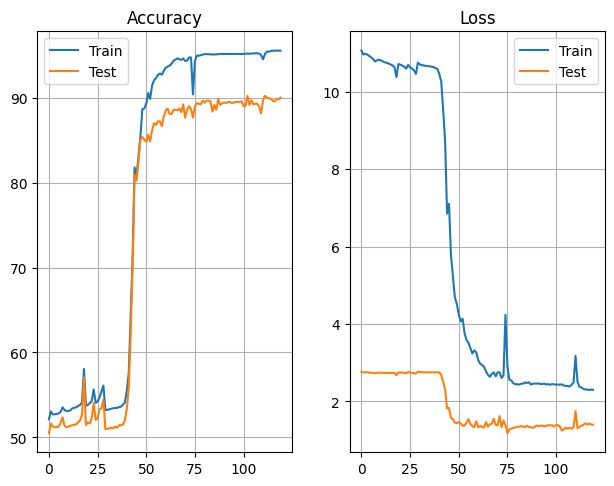

In [72]:
learn_chart(acc_score)

# Метрики

In [5]:
model1 = torch.load('models/2model_102_lstm.pt', weights_only=False)
model1.eval()

LSTM(
  (embedding): Embedding(16459, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (sig): Sigmoid()
)

In [6]:
tokens = {}
with open('datasets/vocabulary.json', 'r') as f:
    tokens = json.load(f)

def predict(texts):
    texts = [preprocess_text(i) for i in texts]
    num_text = texts2tokens(texts)
    # print(num_text)
    max_len = [len(i) for i in num_text]
    same_shape = set_text_len(num_text, max(max_len))
    tensors = torch.IntTensor(same_shape).to(device)

    pred = []
    for i in model1(tensors):
        tmp = i.cpu().argmax()
        # print(tmp)
        tmp = 5 if tmp == 1 else 1
        pred.append(tmp)
    
    return pred

In [16]:
predict(['хороший отель, но есть нюансы',
         'очень шумно на улице не возможно спать по ночам', 
         'плохой отель',
         'На весь отель 3 или 4 фена, которые надо просить на ресепшене,\
         если успеешь. Это очень странно. Забирайте с вечера, если нужен вам.',
         
        'очень не понравилось, что время бежит чертовски быстро. И приближение рабочих дней от крайне не понравилось!',
        '"Я останавливался в этом отеле на выходные, и, к сожалению, мой опыт был далеко не положительным. Номер\
        оказался грязным, с пылью на мебели и неубранной ванной. Персонал был не очень дружелюбным и не реагировал\
        на наши просьбы. Завтрак тоже разочаровал: еда была холодной и не свежей. Я не рекомендую этот отель, так \
        как за такие деньги можно найти гораздо лучшие варианты.',
         'Я провел замечательные дни в этом отеле! Номер был чистым и уютным, с прекрасным видом на город. \
         Персонал был очень вежливым и отзывчивым, всегда готов\
        помочь. Завтрак был разнообразным и вкусным, особенно понравились свежие булочки и кофе. Я обязательно\
        вернусь сюда снова и рекомендую всем, кто ищет комфортное место для отдыха!'])

[5, 1, 1, 5, 1, 1, 5]

In [77]:
def get_pred_y(model, data_loader, device):
    outputs = []
    correct = []
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            outputs.extend(model(X))
            correct.extend(y)

    outputs = [i.cpu().argmax().item() for i in outputs]
    correct = [i.cpu().argmax().item() for i in correct]
    
    return outputs, correct 

In [152]:
predicted, y_test = get_pred_y(model1, test_loader, device)

accuracy_score = metrics.accuracy_score(predicted, y_test)

print(f'Model accuracy = {accuracy_score*100:4.2f}%\n')
print('Classification Report:')
print(metrics.classification_report(y_test, predicted))

Model accuracy = 92.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       710
           1       0.92      0.93      0.92       680

    accuracy                           0.93      1390
   macro avg       0.93      0.93      0.93      1390
weighted avg       0.93      0.93      0.93      1390



Text(0.5, 1.0, 'Confusion Matrix')

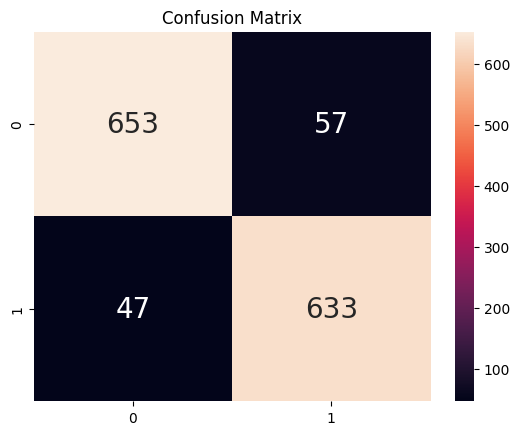

In [153]:
cm = pd.DataFrame(metrics.confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='.0f')
plt.title('Confusion Matrix')

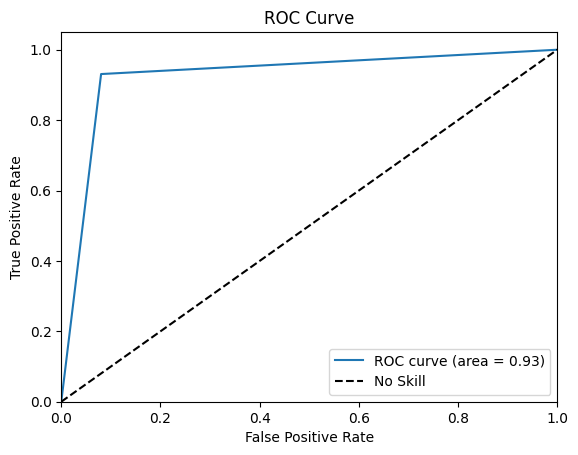

In [154]:
#  TPR = TP/(TP+FN)
# FPR = FP/(FP+TN)

tpr = cm[0][0]/(cm[0][0]+cm[0][1])
fpr = cm[1][0]/(cm[1][0]+cm[1][1])


fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted) 
roc_auc = metrics.auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Tokens

In [103]:
with open('datasets/vocabulary_4.json', 'r') as f:
    tok = json.load(f)
    print(len(tok), tok)

16458 {'кондиционировать': 1, 'окружный': 2, 'заложить': 3, 'бригада': 4, 'вопросительно': 5, 'звукоизоляция': 6, 'почёсывать': 7, 'диаметр': 8, 'совпасть': 9, 'препятствовать': 10, 'сут': 11, 'унизить': 12, 'привлечение': 13, 'изящно': 14, 'гуляка': 15, 'очутиться': 16, 'выяснять': 17, 'блондинка': 18, 'перенести': 19, 'мадридский': 20, 'похитить': 21, 'гетеросексуальный': 22, 'ява': 23, 'старость': 24, 'удостоверение': 25, 'медовый': 26, 'призывать': 27, 'сфабриковать': 28, 'опыт': 29, 'японец': 30, 'руководство': 31, 'болельщик': 32, 'крекер': 33, 'дышаться': 34, 'высококультурный': 35, 'поломать': 36, 'согреваться': 37, 'ит': 38, 'подвозить': 39, 'переправить': 40, 'угрожающе': 41, 'действие': 42, 'сей': 43, 'недосмотр': 44, 'замок': 45, 'миниатюрный': 46, 'выручить': 47, 'драка': 48, 'сбежать': 49, 'сороконожка': 50, 'господь': 51, 'выхватывать': 52, 'размять': 53, 'сюда': 54, 'граммофон': 55, 'полметра': 56, 'пожароопасный': 57, 'возмутить': 58, 'тематика': 59, 'бабник': 60, 'таб

# Test

In [17]:
test_df = pd.read_excel('datasets/booking_ds.xlsx')
test_df

,score,text
0,1,При бронировпнии отеля за два дня цена была 78...
1,1,При заезде мы не успели поменять валюту и нам ...
2,1,"В моем номере был сильный запах сигарет, я про..."
3,1,"нет русскоговорящий персонал , завтрак не вкус..."
4,1,шумная дискотека под окнами до 00:30 в 5:27 на...
...,...,...
93,5,Мелкие проблемы были быстро решены\n\n
94,5,Отель расположен в удачном месте. 3 минуты пеш...
95,5,Отличный отель!Понравился абсолютно во всем.Од...
96,5,"Уют, тишина, хорошее местоположение."


In [18]:
test_score = test_df.score.tolist()
test_text = test_df.text.tolist()

In [19]:
pred = predict(test_text)

In [20]:
acc = []
for i, j in zip(test_score, pred):
    if i==j:
        acc.append(1)
    else:
        acc.append(0)

In [21]:
sum(acc)/len(pred)

0.8367346938775511

In [22]:
for i, text, score in zip(acc, test_text, test_score):
    if i == 0:
        print(score, text)

1 Комнаты маленькие семейные номера без окон, метро рядом шумно, не очень удобная локация , не очень вкусный завтрак в целом повторно не приеду
1 Очень очень долго ждать лифт
1 Чистота. Не убираются нормально. Тяп-ляп.
1 Плохое расположение для туризма - неудобная пешая доступность.
1 Выбрала этот отельдля размещения с друьями, так как впервые были тут с мужем и всё понравлось. Выбирала из-за завтраков. но прогадала. Завтраки испротились. в первые день было очень скудно, мне было стыдно перед друзьями, второй день было лучше. Если пойдёте на ужин, готовьте тысяч 6000р на двоих с бокалом вина, это оч дорого для ресторана в отеле. Покушайте где-то рядом, там у вокзала есть хороший ресторан. До центра можно добраться на автобусе или такси.
1 Завтрак! который начинается с 9 (!!!) утра. Отель в городе у автовокзала Ортачала, в котором завтрак с 9 утра - это полный бред. Мой автобус, например, уезжал в 8-30 утра. Я заплатил 170 GEL за ночь за бронирование с завтраком, в итоге переночевал и у